In [1]:
#SELECTION DEFINITION

THE_BIG_SELECTION = (
    "((Dst_M - D0_M) > 143) & ((Dst_M - D0_M) < 148) & "
    "(K_IPCHI2_OWNPV > 3) & (pi_IPCHI2_OWNPV > 3) & "
    "(K_TRACK_CHI2NDOF < 1.7) & (pi_TRACK_CHI2NDOF < 1.7) & "
    "(K_PT > 250) & (pi_PT > 250) & "
    "(K_hasRich == 1) & (pi_hasRich == 1) & "
    "(mp_TRACK_CHI2NDOF < 2) & "
    "(mm_TRACK_CHI2NDOF < 2) & "
    "(mp_isMuon == 1) & (mm_isMuon == 1) & "
    "(mp_PIDmu > 0) & (mm_PIDmu > 0) & "
    "(mp_PT > 700) & (mm_PT > 700) & "
    "(mp_IPCHI2_OWNPV > 2) & (mm_IPCHI2_OWNPV > 2) & "
    "(Jpsi_M < 3140) & (Jpsi_M > 3040) & "
    "(pi_soft_PT > 250) & "
    "(Bc_ENDVERTEX_CHI2 < 4.2) & "
    "(Bc_IPCHI2_OWNPV < 10) & "
    "(Bc_DIRA_OWNPV > 0.99)"
)


In [2]:
#IMPORTING LIBRARIES
import uproot
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBClassifier, callback, plot_importance
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
import pickle
from datetime import datetime
import optuna
import joblib
from sklearn.datasets import make_classification
# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.linear_model import LogisticRegression
import pickle


/Users/khrystina/new_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#DATA DOWNLOADING
files_simu = [
    './simulation/2011_MagDown.root', 
    './simulation/2015_MagDown.root',
    './simulation/2015_MagUp.root',
    './simulation/2016_MagDown.root',
    './simulation/2016_MagUp.root',
    './simulation/2017_MagDown.root',
    './simulation/2017_MagUp.root',
    './simulation/2018_MagDown.root',
    './simulation/2018_MagUp.root'
]

files_real_data = [
    './real_data/2011_MagDown.root', 
    './real_data/2011_MagUp.root',
    './real_data/2012_MagDown.root', 
    './real_data/2012_MagUp.root',
    './real_data/2015_MagDown.root', 
    './real_data/2015_MagUp.root',
    './real_data/2016_MagDown.root', 
    './real_data/2016_MagUp.root',
    './real_data/2017_MagDown.root', 
    './real_data/2017_MagUp.root',
    './real_data/2018_MagDown.root', 
    './real_data/2018_MagUp.root'
]
simu_data = uproot.concatenate(files_simu, cut = f"{THE_BIG_SELECTION} & (Bc_BKGCAT == 0)", library='pd')
real_data = uproot.concatenate(files_real_data, cut = f"{THE_BIG_SELECTION} & (Bc_M > 6600.)", library='pd')
real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']

/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3096/2730945960.py:30: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  real_data['delta_mass'] = real_data['Dst_M'] - real_data['D0_M']
/var/folders/mh/zhwzz3rj1_7dnp568ry0gfpm0000gs/T/ipykernel_3096/2730945960.py:31: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  simu_data['delta_mass'] = simu_data['Dst_M'] - simu_data['D0_M']


In [4]:
#DEFINING TRAINING FEATURES

feature_columns = [

    'mp_PT',
    'mm_PT',
    'Bc_ENDVERTEX_CHI2',
    'Bc_IPCHI2_OWNPV',

    'Bc_FD_OWNPV',
    'Jpsi_FD_ORIVX',
    'D0_FD_ORIVX'
    ]

In [5]:
#PREPARING DATASET
# Separate features and labels
X_simu = simu_data[feature_columns]
y_simu = np.ones(len(simu_data))  # Label: 1 for simulation data

X_real = real_data[feature_columns]
y_real = np.zeros(len(real_data))  # Label: 0 for real data

# Combine features and labels
X_all = pd.concat([X_simu, X_real], ignore_index=True)
y_all = np.concatenate([y_simu, y_real]) 

print(f"SIMULATION set size: {X_simu.shape}")
print(f"REAL DATA set size: {X_real.shape}")


SIMULATION set size: (28209, 7)
REAL DATA set size: (1229, 7)


In [8]:
#TIME FUNCTION

def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    else:
        elapsed_time = datetime.now() - start_time
        thour, temp_sec = divmod(elapsed_time.total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %d hours, %d minutes, and %.2f seconds.' % (int(thour), int(tmin), tsec))


In [9]:
#IMPLEMENTING OPTUNA TO FIND THE BEST MODEL

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=76)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 2, 20)
    }
    model_optuna = XGBClassifier(**params, random_state=52, eval_metric="logloss")
    model_optuna.fit(X_train, y_train)
    preds = model_optuna.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, preds)
    if not hasattr(objective, 'best_score') or score > objective.best_score:
        objective.best_score = score
        objective.best_model = model_optuna 
    return score

# Optimize
study = optuna.create_study(direction="maximize")
start_time = timer(None)
study.optimize(objective, n_trials=400)
best_model = objective.best_model
joblib.dump(best_model, "best_optuna_model.pkl")
timer(start_time)

print("Best parameters:", study.best_params)
print("Best ROC-AUC Score:", study.best_value)
print("Best model saved as 'best_optuna_model.pkl'")


[I 2025-02-06 16:46:32,640] A new study created in memory with name: no-name-60b13759-9162-4508-ad19-632f160b5110


Training set size: (23550, 7)
Test set size: (5888, 7)


[I 2025-02-06 16:46:35,260] Trial 0 finished with value: 0.9639016456180636 and parameters: {'n_estimators': 439, 'learning_rate': 0.012892449212341206, 'max_depth': 15}. Best is trial 0 with value: 0.9639016456180636.
[I 2025-02-06 16:46:35,803] Trial 1 finished with value: 0.9601836285604942 and parameters: {'n_estimators': 324, 'learning_rate': 0.1564408542447686, 'max_depth': 5}. Best is trial 0 with value: 0.9639016456180636.
[I 2025-02-06 16:46:37,084] Trial 2 finished with value: 0.9582796867311791 and parameters: {'n_estimators': 372, 'learning_rate': 0.29027687595693635, 'max_depth': 18}. Best is trial 0 with value: 0.9639016456180636.
[I 2025-02-06 16:46:37,622] Trial 3 finished with value: 0.9675427806024822 and parameters: {'n_estimators': 471, 'learning_rate': 0.03881401832847809, 'max_depth': 3}. Best is trial 3 with value: 0.9675427806024822.
[I 2025-02-06 16:46:37,990] Trial 4 finished with value: 0.9673633890984636 and parameters: {'n_estimators': 473, 'learning_rate':


 Time taken: 0 hours, 3 minutes, and 21.76 seconds.
Best parameters: {'n_estimators': 275, 'learning_rate': 0.022426499541406842, 'max_depth': 4}
Best ROC-AUC Score: 0.9693824831884533
Best model saved as 'best_optuna_model.pkl'


In [10]:
#TRAINING MODEL WITH K-FOLD AND EARLY STOPPING

n_folds = 5
fold_accuracies = []

kf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=11)

# Load Optuna-saved model parameters
with open("best_optuna_model.pkl", "rb") as file:
    best_model_params = pickle.load(file)
try:
    print(best_model_params) 
except ImportError as e:
    print("ImportError occurred:", e)

# Ensure parameters are valid for XGBClassifier
if hasattr(best_model_params, 'get_params'):
    best_model_params = best_model_params.get_params()


best_model_params.update({
    'random_state': 51, 
    'eval_metric': 'logloss' ,
    'early_stopping_rounds': 20 
})

classif_list = []
# Perform k-fold cross-validation
for fold, (train_index, val_index) in enumerate(kf.split(X_all, y_all)):
    print(f"Processing Fold {fold + 1}/{n_folds}...")
    # Initialize the model with the best parameters
    model_es = XGBClassifier(**best_model_params)
    # Split the data using iloc for pandas DataFrame compatibility
    X_train, X_val = X_all.iloc[train_index], X_all.iloc[val_index]
    y_train, y_val = y_all[train_index], y_all[val_index]

    

    # Fit the model with early stopping
    model_es.fit(
        X_train,
        y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    classif_list.append(model_es)
    # Evaluate the model on the validation set
    y_pred = model_es.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    fold_accuracies.append(acc)
    print(f"Fold {fold + 1} Accuracy: {acc:.4f}")

mean_accuracy = np.mean(fold_accuracies)
print(f"\nMean Cross-Validation Accuracy: {mean_accuracy:.4f}")

model_es.save_model("best_kfold_early_stopping_model.json")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.022426499541406842, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=275, n_jobs=None,
              num_parallel_tree=None, random_state=52, ...)
Processing Fold 1/5...
Fold 1 Accuracy: 0.9710
Processing Fold 2/5...
Fold 2 Accuracy: 0.9727
Processing Fold 3/5...
Fold 3 Accuracy: 0.9711
Processing Fold 4/5...
Fold 4 Accuracy: 0.9728
Processing Fold 5/5...
Fo

In [11]:
#ACCURACY

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=92)
# Predict on the test set
y_pred = classif_list[0].predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Predict on the test set
y_pred = classif_list[1].predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Generate a classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.53      0.66       264
         1.0       0.98      1.00      0.99      5624

    accuracy                           0.98      5888
   macro avg       0.92      0.77      0.82      5888
weighted avg       0.97      0.98      0.97      5888

Accuracy: 0.98
Classification Report:
              precision    recall  f1-score   support

         0.0       0.86      0.55      0.67       264
         1.0       0.98      1.00      0.99      5624

    accuracy                           0.98      5888
   macro avg       0.92      0.77      0.83      5888
weighted avg       0.97      0.98      0.97      5888



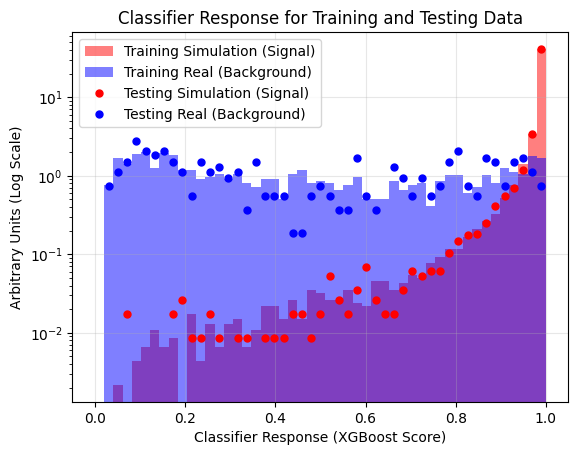

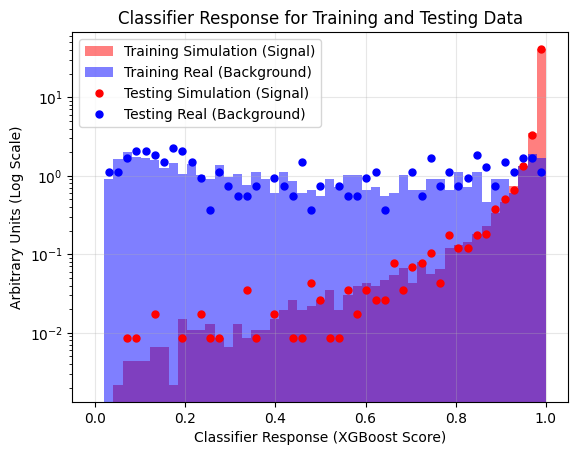

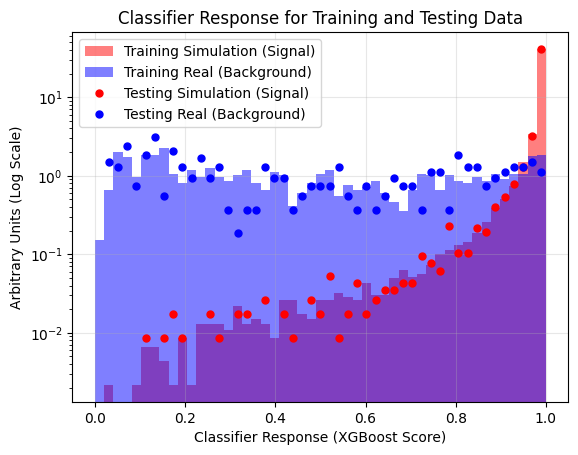

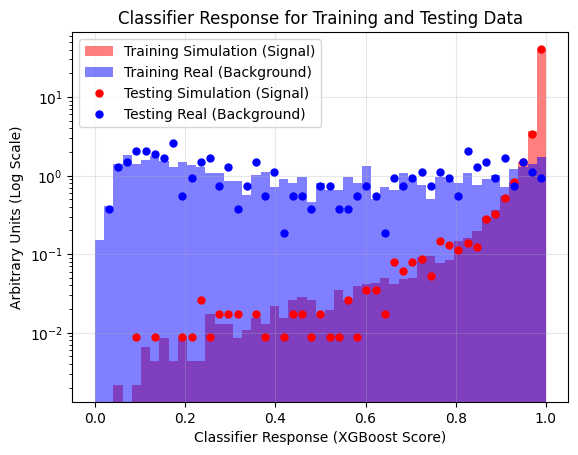

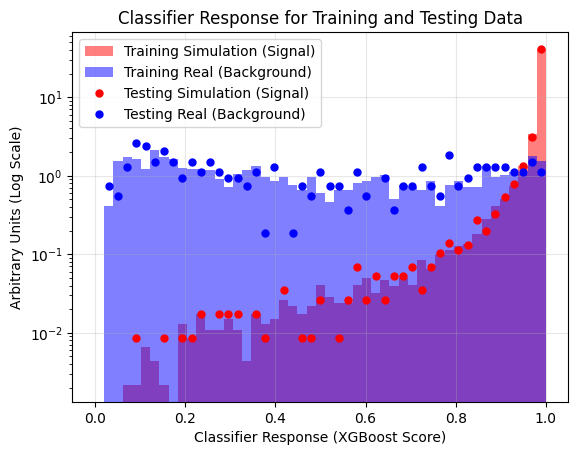

In [12]:
numb_of_classif = 5


for i in range (numb_of_classif):

    # Combine signal and background predictions for each set
    train_sim_signal = classif_list[i].predict_proba(X_train[y_train == 1])[:, 1]
    train_real_background = classif_list[i].predict_proba(X_train[y_train == 0])[:, 1]
    test_sim_signal = classif_list[i].predict_proba(X_test[y_test == 1])[:, 1]
    test_real_background = classif_list[i].predict_proba(X_test[y_test == 0])[:, 1]

    # Define bins for histograms
    bins = np.linspace(0, 1, 50)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # Histograms for training data
    train_sim_hist, _ = np.histogram(train_sim_signal, bins=bins, density=True)
    train_real_hist, _ = np.histogram(train_real_background, bins=bins, density=True)

    # Histograms for test data (used for alignment)
    test_sim_hist, _ = np.histogram(test_sim_signal, bins=bins, density=True)
    test_real_hist, _ = np.histogram(test_real_background, bins=bins, density=True)

    # Plot histograms for training data
    plt.hist(train_sim_signal, bins=bins, alpha=0.5, label="Training Simulation (Signal)", color="red", density=True, histtype="stepfilled")
    plt.hist(train_real_background, bins=bins, alpha=0.5, label="Training Real (Background)", color="blue", density=True, histtype="stepfilled")

    # Plot test data as dots
    plt.plot(bin_centers, test_sim_hist, 'o', label="Testing Simulation (Signal)", color="red", markersize=5)
    plt.plot(bin_centers, test_real_hist, 'o', label="Testing Real (Background)", color="blue", markersize=5)

    # Labels, legend, and title
    plt.xlabel("Classifier Response (XGBoost Score)")
    plt.ylabel("Arbitrary Units (Log Scale)")
    plt.title("Classifier Response for Training and Testing Data")
    plt.legend()
    plt.yscale("log")  # Logarithmic scale for better visualization
    plt.grid(alpha=0.3)

    plt.show()


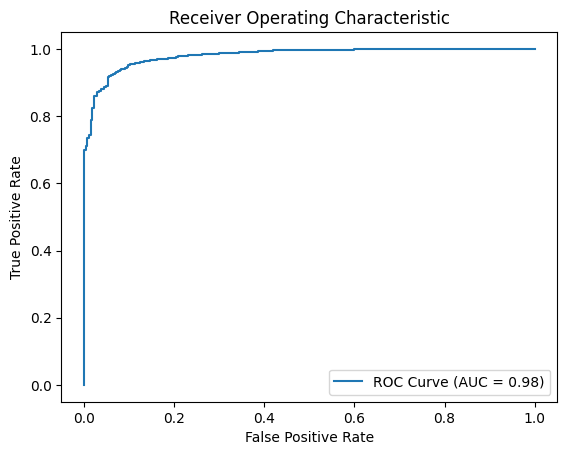

In [13]:

y_prob = model_es.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


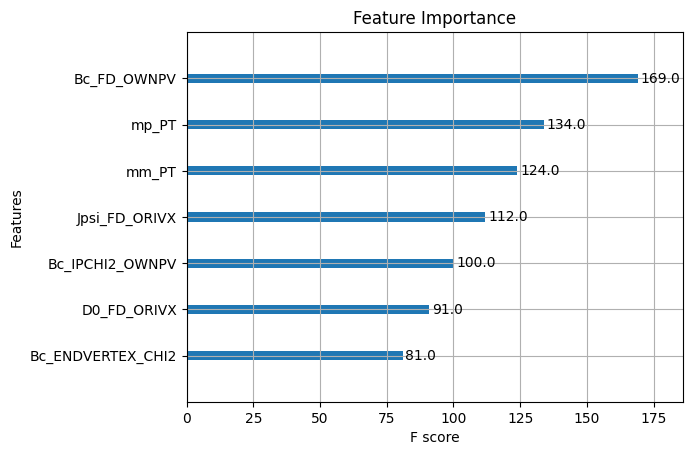

In [40]:

# Plot feature importance
plot_importance(model_es, importance_type='weight')
plt.title("Feature Importance")
plt.show()
